# **Modelling and Evaluation Notebook**

## Objectives

* Answer business requirement 2:
  - The client wants to have a ML model so that we can use it to test their HIP software.

## Inputs

* inputs/cats_vs_dogs_dataset/train
* inputs/cats_vs_dogs_dataset/validation
* inputs/cats_vs_dogs_dataset/test
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation
* Machine learning model creation and training.
* Learning curve plot for model performance.
* Model evaluation on pickle file.

## Additional Comments

* 


---

# **Preparation setup**

## Import libraries

In [ ]:
%pip install -r /workspace/pp5-cats-vs-dogs/requirements.txt 2>/dev/null | grep -v 'Requirement already satisfied'
print('Requirements installed.')

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Set working directory

Set working directory to root project folder

In [ ]:
current_dir = os.getcwd()
print('Current folder: ' + current_dir)
os.chdir(os.path.dirname(current_dir))
root_dir = os.getcwd()
print('New folder: ' + root_dir)

## Set input directories

In [24]:
dataset_folder = 'inputs/cats_vs_dogs_dataset_small'
train_path = dataset_folder + '/train'
validation_path = dataset_folder + '/validation'
test_path = dataset_folder + '/test'
train_path

'inputs/cats_vs_dogs_dataset_small/train'

## Set output directory

In [31]:
version = 'v6'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(root_dir) and version in os.listdir(root_dir + '/outputs'):
    print(f'Version {version} is already available.')
    pass
else:
    os.makedirs(name=file_path)
    print(f'New directory for version {version} has been created')

New directory for version v6 has been created


## Set label names

In [ ]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

## Set image shape

In [37]:
version = 'v3'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(120, 134, 3)

## Number of images in dataset

In [ ]:
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        new_row = pd.DataFrame({
            'Set': [folder],
            'Label': [label],
            'Frequency': [len(os.listdir(dataset_folder + '/' + folder + '/' + label))]
        })
        df_freq = pd.concat([df_freq, new_row], ignore_index=True)

        print(
            f"* {folder} - {label}: {len(os.listdir(dataset_folder +'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

# **Image data augmentation**

## Initialize image data generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

## Augment training, validation and test image datasets

In [38]:
batch_size = 20

train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

train_set.class_indices

Found 3500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


{'cat': 0, 'dog': 1}

## Plot augmented training image

In [ ]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation and test images

In [ ]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

In [ ]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Save class indicies

In [ ]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

---

# **Model creation**

## ML model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

### Summary

In [39]:
create_tf_model().summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 118, 132, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 59, 66, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 57, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 28, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 26, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 15, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6240)             

### Early stopping

In [40]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=4)

### Fit model for training

In [41]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
175/175 [==============================] - 19s 108ms/step - loss: 0.6939 - accuracy: 0.5166 - val_loss: 0.6864 - val_accuracy: 0.5000
Epoch 2/25
175/175 [==============================] - 17s 100ms/step - loss: 0.6837 - accuracy: 0.5680 - val_loss: 0.7033 - val_accuracy: 0.5300
Epoch 3/25
175/175 [==============================] - 16s 90ms/step - loss: 0.6783 - accuracy: 0.5743 - val_loss: 0.6801 - val_accuracy: 0.5700
Epoch 4/25
175/175 [==============================] - 20s 115ms/step - loss: 0.6691 - accuracy: 0.6006 - val_loss: 0.6424 - val_accuracy: 0.6380
Epoch 5/25
175/175 [==============================] - 13s 76ms/step - loss: 0.6597 - accuracy: 0.6080 - val_loss: 0.6405 - val_accuracy: 0.6460
Epoch 6/25
175/175 [==============================] - 20s 116ms/step - loss: 0.6523 - accuracy: 0.6266 - val_loss: 0.6312 - val_accuracy: 0.6580
Epoch 7/25
175/175 [==============================] - 15s 87ms/step - loss: 0.6335 - accuracy: 0.6469 - val_loss: 0.6367 - val_accur

### Save the model

In [42]:
model.save(f'{file_path}/cats_vs_dogs_model.h5')

---
## Model performance

### Model learning curve

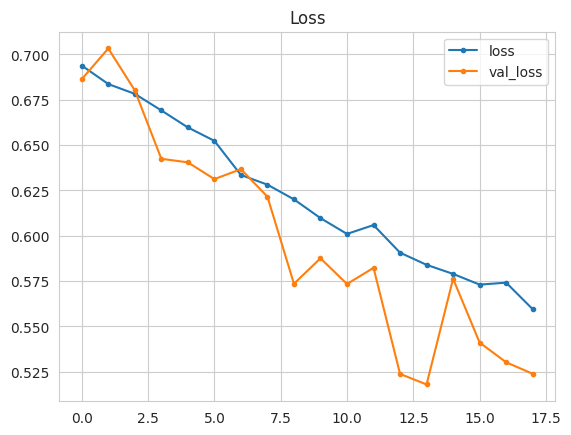

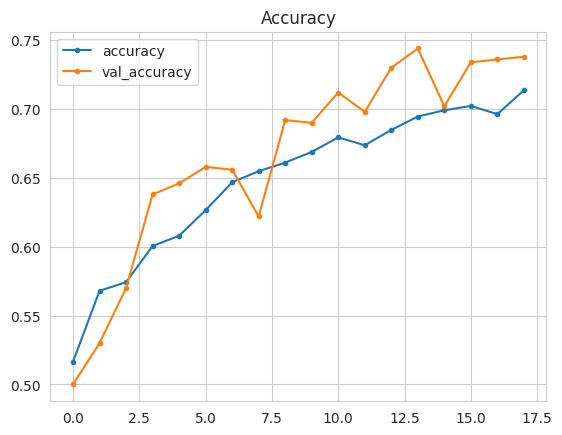

In [43]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Model evaluation

#### Load model

In [44]:
from keras.models import load_model
model = load_model(f'{file_path}/cats_vs_dogs_model.h5')

#### Evaluate on the test set

In [45]:
evaluation = model.evaluate(test_set)

50/50 [==============================] - 2s 37ms/step - loss: 0.5637 - accuracy: 0.7000


#### Save evaluation

In [46]:
joblib.dump(value=evaluation,
            filename=f'{file_path}/evaluation.pkl')

['outputs/v6/evaluation.pkl']

### Predict on new data

#### Load random image as PIL

In [ ]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

#### Convert image to array

In [ ]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

#### Predict class on the image

In [ ]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

---
# Push files to Repo

Check changed files:

In [ ]:
!git status

Add, commit and push to repo (all files or individual file)

In [ ]:
!git add .

!git commit -m "Message"

!git push

# Conclusions

Model v1
- 0,7986 acc, 62 min to fit
- Conv2D -> filters= 32 -> 64 -> 64 = 16,9 mil params
- Modelsize 388 mb - deleted

New v1
- 0,9223 acc, 19 min to fit
- Conv2D -> filters= 16 -> 32 -> 32 = 8,4 mil params
- Modelsize 97 mb - saved and pushed to github

**Nr of params affect modelsize.**

New v1 with evaluation
- 0.8254, 43 min to fit (slow gitpod workspace)
- Conv2D -> filters= 16 -> 32 -> 32 = 8,4 mil params
- Modelsize 97 mb - saved and pushed to github


V2 
- Used softmax instead of sigmoid
- loss: 1.0727 - accuracy: 0.6230 on test set
- 16 min to train

V3
- Reduced image size to 25% of average
- loss: 0.7066 - accuracy: 0.5120
- 22 seconds to train

New V3
- reduced image size to 50% of average
- loss: 0.6775 - accuracy: 0.6520
- 3 min 25 sec to train
- modelsize = 22 mb

V4
- Add image augmentation
- loss: 0.5591 - accuracy: 0.7220
- 5 min to train
- modelsize = 22mb

V5
- Increase to 25 epochs
- Use all 25000 dataset images
- Reduced image size to 25% of average
- loss: 0.3806 - accuracy: 0.8318
- 24 min to train 
- modelsize = 4 MB

V6
- use smaller 5000 img dataset
- Reduced image size to 33% of average
- loss: 0.5637 - accuracy: 0.7000
- 5 min to train, ended on 18 epochs
- modelsize = ?
